In [105]:
#to manipulate the data
import numpy as np
import pandas as pd
import os
#for plotting 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from keras_visualizer import visualizer 

# Data split and selection 
from sklearn.utils import shuffle
from sklearn.utils import class_weight as cw
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report

# keras preprocessing for images 
from keras.preprocessing.image import ImageDataGenerator

#deep learning callbacks arapmater
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras import backend as K
import gc
#time and date
import time 
import datetime

# Deep learning model paramters 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
#Define the directory for data 
input_directory = r"data/"
data_dir = input_directory + r"train"
# getting all the images names 
data_files = os.listdir(data_dir)
#getting all the labels name
data_labels = [file.split(".")[0] for file in data_files ]
#making a data frame 
df_data = pd.DataFrame({"id": data_files, "label": data_labels})
df_data.head()

,id,label
0,dog.8011.jpg,dog
1,cat.5077.jpg,cat
2,dog.7322.jpg,dog
3,cat.2718.jpg,cat
4,cat.10151.jpg,cat


In [3]:
def get_class_id(df, file="id", label = "label", n=5):
    """This function will seprate the labels from a given
    Data Frame and will get n image randomly for each class
    """
    label_map = {}
    for l in df[label].unique():
        label_map[l] = df[df.label==l].sample(n).id.tolist()
    return label_map
def plot_sample_image(label_map_select,n, directory=data_dir, figsize=(16, 5), aspect='auto'):
    
    nrows=len(label_map_select)
    ncols=n
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)    
    i=0
    for label in label_map_select:
        print(label)
        j=0
        for file in label_map_select[label]:
            plt.subplot(i+1, ncols, j+1)
            plot_image(file, directory, aspect=aspect)
            j=j+1
        plt.tight_layout()
        plt.show()
        i+=1
def plot_image(file, directory=None, aspect=None,text=None,size=None):
    #show one image 
    path = directory +"/"+ file
    
    img = plt.imread(path)
    if size:
        plt.figure(figsize=size)
    
    plt.imshow(img, aspect=aspect)

    plt.xticks([])
    plt.yticks([])

    plt.title(path.split("/")[-1])
    if text:
        plt.title(text)


What's my data looks like:

dog


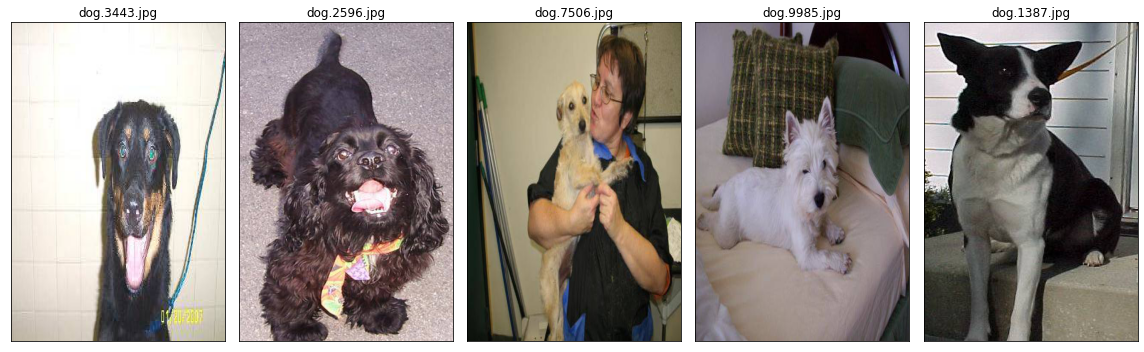

cat


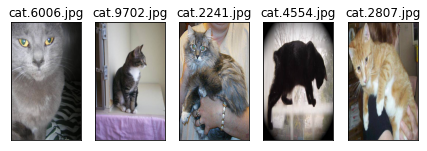

In [4]:
print("What's my data looks like:\n")
plot_sample_image(get_class_id(df_data),5)

We have 25000 images of :
dog    12500
cat    12500


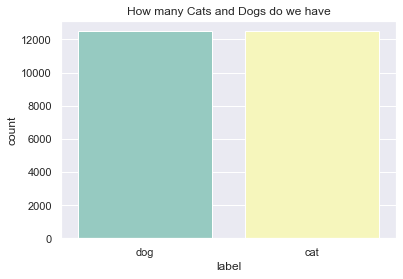

In [5]:
sns.set_theme(style="darkgrid")
ax=sns.countplot(data=df_data,
    x="label",palette="Set3").set(title='How many Cats and Dogs do we have')
print("We have",len(df_data),"images of :")
print(df_data.label.value_counts().to_string())


In [6]:
#spliting the data into train and split 80% - 20% according to the label
X_train, X_test, y_train, y_test = train_test_split(
     df_data, df_data.label, test_size=0.2, random_state=42
    ,stratify=df_data.label)
classes = y_train.unique().tolist()

In [78]:
#pre proccsing data with ImageDataGenerator from keras and to be able
# to get the image and train the data chunk by chunk 
def get_data(batch_size=32, target_size=(32,32), 
    class_mode="categorical", dir_=data_dir, 
     classes=classes, df_train=X_train, df_test=X_test):
    print("Generating data following preprocessing...\n")
    rescale = 1.0/255 # for scaling the images 
    train_batch_size = batch_size #loading image batch for training
    test_batch_size = batch_size#loading image batch for testing
    #shuffle data
    train_shuffle = True  
    val_shuffle = True
    test_shuffle = False
    #geting the image and re propossing 
    train_datagen = ImageDataGenerator(
        #rotation_range=30, 
        #fill_mode='nearest',
       horizontal_flip=True,#randomly flipping half of the images horizontally
         #vertical_flip=True,
        #width_shift_range=0.2, 
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        #brightness_range=[0.4,1.5],
        rescale=rescale,#re scaling between 0 and 1 
        validation_split=0.05 # spleting traing data to validation and traning 
)
    #train data
    train_generator = train_datagen.flow_from_dataframe(
        df_train, #traing data frame 
        dir_, #direcory 
        x_col='id', #
        y_col='label', 
        target_size=target_size, 
        classes = classes,
        class_mode=class_mode, 
        batch_size=batch_size, 
        shuffle=True, 
        seed=42,
        subset='training')
    #validation data 
    validation_generator = train_datagen.flow_from_dataframe(
        df_train, 
        dir_, 
        x_col='id',
        y_col='label', 
        target_size=target_size, 
        classes = classes,
        class_mode=class_mode, 
        batch_size=batch_size, 
        shuffle=True, 
        seed=42,
        subset='validation')
    #test tranform data 
    test_datagen = ImageDataGenerator(rescale=rescale)
    test_generator = test_datagen.flow_from_dataframe(
        df_test, 
        dir_, 
        x_col='id',
        y_col='label', 
        target_size=target_size, 
        classes = classes,
        class_mode=class_mode, 
        batch_size=batch_size, 
        shuffle=False
#         seed=42
    )
    #weight to respect the representation of each class 
    class_weights = get_weight(train_generator.classes)
    steps_per_epoch = len(train_generator)
    validation_steps = len(validation_generator)
    print("\nData batches generated.")
    return train_generator, validation_generator, test_generator, class_weights, steps_per_epoch, validation_steps
def get_weight(y):
    #to get weight if there is over representing 
    class_weight_current =  cw.compute_class_weight('balanced', classes=np.unique(y),y= y)
    return class_weight_current

In [73]:
main_model_dir = r"models/"
main_log_dir = r"logs/"
#to check if file dose not exsit already 
try:
    shutil.rmtree(main_model_dir)
except:
    pass
try:
    shutil.rmtree(main_log_dir)
except:
    pass
try :
    os.mkdir(main_log_dir)
    
except FileExistsError :
    pass
try:
    os.mkdir(main_model_dir)    
except FileExistsError:  
    pass

model_dir = main_model_dir +"dog_vs_cat_"+ time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir +"dog_vs_cat_"+ time.strftime('%Y-%m-%d %H-%M-%S')

os.mkdir(model_dir)
os.mkdir(log_dir)

model_file = model_dir + "{epoch:02d}-val_acc-{val_accuracy:.2f}-val_loss-{val_loss:.2f}.hdf5"
model_dir, os.listdir(model_dir), log_dir, os.listdir(log_dir)

('models/dog_vs_cat_2022-04-21 14-25-19/',
 [],
 'logs/dog_vs_cat_2022-04-21 14-25-19',
 [])

In [79]:
print("Settting Callbacks")
#after 5 tries if Validation loss is not any better than stop
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    verbose=1,
    restore_best_weights=True)# save the best wight model

# after two tries if Validation loss is not any better than reduce learnig rate 
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=1)
# to save model wights for future predections 
checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_accuracy', 
    save_best_only=True)
# keep traking all the models and to plot them later all togerther 
tensorboard = TensorBoard(
    log_dir=log_dir,
    update_freq='batch')
callbacks = [reduce_lr, early_stopping,checkpoint,tensorboard]
print("Completed")
model_dir, os.listdir(model_dir), log_dir, os.listdir(log_dir)

Settting Callbacks
Completed


('models/dog_vs_cat_2022-04-21 14-25-19/',
 [],
 'logs/dog_vs_cat_2022-04-21 14-25-19',
 [])

In [100]:
#Building my model

def get_conv_model():
    model = Sequential()
    #Convolutional
    model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(32,32 ,3)))
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    

    model.add(Flatten())
    #fully connected 
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    #output 
    model.add(Dense(2 , activation='softmax'))
    
    return model
get_conv_model().summary()


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_232 (Conv2D)         (None, 32, 32, 16)        448       
                                                                 
 conv2d_233 (Conv2D)         (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_116 (MaxPooli  (None, 16, 16, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_234 (Conv2D)         (None, 16, 16, 32)        4640      
                                                                 
 conv2d_235 (Conv2D)         (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_117 (MaxPooli  (None, 8, 8, 32)         0         
 ng2D)                                               

In [91]:
# print date and time for given type of representation
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()
#plot_performance
def plot_performance(history=None, figure_directory=None):
    #ploting model Performance 
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']
    ylim_pad = [0.01, 0.1]
    plt.figure(figsize=(15, 5))
    # Plot training & validation Accuracy values
    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']
    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]
    plt.subplot(121)
    plt.plot(y1)
    plt.plot(y2)
    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    # Plot training & validation loss values
    y1 = history.history['loss']
    y2 = history.history['val_loss']
    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]
    plt.subplot(122)
    plt.plot(y1)
    plt.plot(y2)
    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
#     plt.savefig(figure_directory+"/history")
    plt.show()

In [99]:

print("Starting...\n")
start_time = time.time()
batch_size = 32
target_size = (32, 32)
train_generator, validation_generator, test_generator, class_weights, steps_per_epoch, validation_steps = get_data(batch_size=batch_size, target_size=target_size, classes=classes, df_test=X_test)
print("\n\nCompleted\n")

Starting...

Generating data following preprocessing...

Found 19000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.

Data batches generated.


Completed



In [93]:
start_time = time.time()
loss = 'categorical_crossentropy'
metrics = ['accuracy']
verbose = 1
epochs = 50
model=get_conv_model()
print("\n\nCompliling Model ...\n")
learning_rate = 0.0001
optimizer = Adam(learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

#fit
print("Starting...\n")
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=verbose,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps, 
    class_weight=dict(enumerate(class_weights)))
elapsed_time = time.time() - start_time
print("\nElapsed Time: " , elapsed_time)


Starting...



Compliling Model ...

Epoch 1/50
594/594 [==============================] - 72s 120ms/step - loss: 0.6700 - accuracy: 0.5799 - val_loss: 0.6357 - val_accuracy: 0.6310 - lr: 1.0000e-04
Epoch 2/50
594/594 [==============================] - 70s 117ms/step - loss: 0.6194 - accuracy: 0.6613 - val_loss: 0.6210 - val_accuracy: 0.6580 - lr: 1.0000e-04
Epoch 3/50
594/594 [==============================] - 70s 118ms/step - loss: 0.5827 - accuracy: 0.6920 - val_loss: 0.5776 - val_accuracy: 0.6990 - lr: 1.0000e-04
Epoch 4/50
594/594 [==============================] - 70s 118ms/step - loss: 0.5421 - accuracy: 0.7252 - val_loss: 0.5491 - val_accuracy: 0.7100 - lr: 1.0000e-04
Epoch 5/50
594/594 [==============================] - 71s 119ms/step - loss: 0.5240 - accuracy: 0.7387 - val_loss: 0.5218 - val_accuracy: 0.7450 - lr: 1.0000e-04
Epoch 6/50
594/594 [==============================] - 71s 120ms/step - loss: 0.5053 - accuracy: 0.7521 - val_loss: 0.5098 - val_accuracy: 0.7590 - lr: 1.

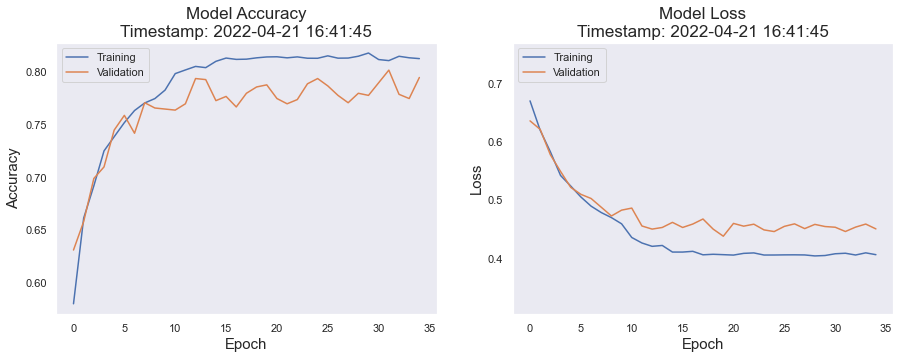

In [94]:
plot_performance(history=history)

In [95]:
# result of the test 
y_preds = model.predict(test_generator ,verbose=1) 
preds=["dog" if i ==1 else "cat" for i in np.argmax(y_preds,axis=1) ]
print(classification_report(y_test,preds))

157/157 [==============================] - 13s 83ms/step
              precision    recall  f1-score   support

         cat       0.87      0.69      0.77      2500
         dog       0.74      0.90      0.81      2500

    accuracy                           0.79      5000
   macro avg       0.81      0.79      0.79      5000
weighted avg       0.81      0.79      0.79      5000



Found 2 validated image filenames belonging to 2 classes.
1/1 [==============================] - 0s 286ms/step


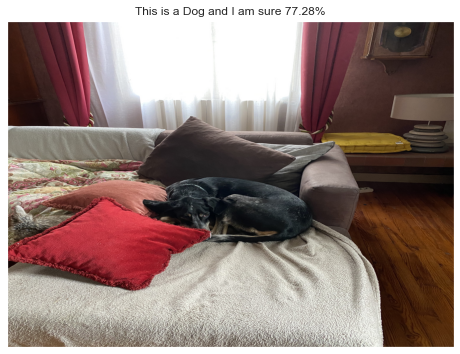

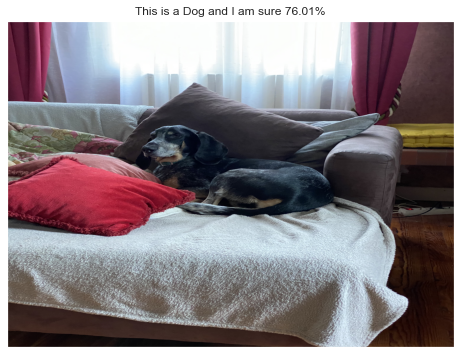

In [96]:
#Trying out my model on my dog 
df_test1 = pd.DataFrame({"id": ["234.jpg","IMG_2029.jpg"]})
df_test1["label"] = "cat"
test_per = ImageDataGenerator(rescale=1/255)
test_generator_per = test_per.flow_from_dataframe(
    df_test1, 
    input_directory, 
    x_col='id',
    y_col='label', 
    target_size=(32, 32), 
    classes = classes,
    class_mode="categorical", 
    batch_size=32, 
    shuffle=False)
#test sur mon chien :-)

pres = model.predict(test_generator_per, steps=len(test_generator_per), verbose=1) 

a_=["Dog" if i ==1 else "Cat" for i in np.argmax(pres,axis=1) ]
for i,photo in enumerate(df_test1.id): 
    text=f"This is a {a_[i]} and I am sure {max(pres[i])*100:.2f}%"
    plot_image(photo,"data/",text=text,size=(8,6),aspect="auto")

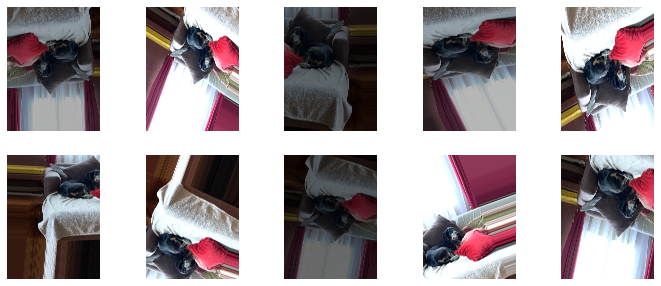

In [451]:


img1 = plt.imread("data/IMG_2029.jpg")
datagen = ImageDataGenerator( fill_mode='nearest',
        width_shift_range=0.3, height_shift_range=0.3
        ,zoom_range=0.3,
        rotation_range=30, 
       horizontal_flip=True,#randomly flipping half of the images horizontally
         vertical_flip=True,
        shear_range=0.2,
     brightness_range=[0.4,1.5])
# iterator
aug_iter = datagen.flow(np.array([img1]),batch_size=10)

# generate samples and plot
nrows,ncols=2,5
fig=plt.figure(figsize=(12, 5))
for i in range(1, nrows*ncols +1):
    # convert to unsigned integers
    image = next(aug_iter)[0].astype('uint8')
#       plt.subplot(g+1, ncols, k+1)
    fig.add_subplot(nrows, ncols, i)
    plt.imshow(image)
    plt.axis("off")
plt.show()


(-0.5, 3023.5, 4031.5, -0.5)

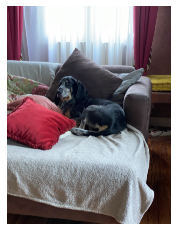

In [380]:
#orignal photo
fig, ax = plt.subplots()
ax.imshow(img1)
ax.axis('off')

In [106]:
#%pip install ann_visualizer
#from ann_visualizer.visualize import ann_viz
#ann_viz(get_conv_model(), title="Model")
#from keras_visualizer import visualizer 

#to visualizer the graph
visualizer(get_conv_model(), format='png', view=True)

In [116]:
k=""
for i in range(1,3+1):
    
    k+=str(i)
        
    print(k)

1
12
123


In [137]:
students = [['Harry', 37.21], ['Berry', 37.21], ['Tina', 37.2], ['Akriti', 41], ['Harsh', 39]]
ff=sorted(students,key=lambda item: (item[1],item[0] ))
for i in ff[:2]:
        print(i[0])
        
ff[1][1]==ff[2][1]

Tina
Berry


True